# فراخوانی کتابخانه ها

In [2]:
import gym                                        #جعبه ابزار OpenAI GYM (برای ساخت محیط) 
import numpy as np                                #کتابخانه های ریاضی پایتون برای کار با ماتریس ها
import torch                                      #کتابخانه ترچ برای کار با شبکه های عصبی عمیق
from torch import nn                              #کلاس شبکه های عصبی عمیق از کتابخانه پایترچ
import matplotlib.pyplot as plt                   #کتابخانه برای رسم نمودار

# ساخت شبکه های عصبی عمیق

In [3]:
class Actor(nn.Module):                           #کلاس برای تعریف قسمت رو به جلو شبکه بازیگر
    def __init__(self, states, actions):     #ورودی آن حالت ها و خروجی آن احتمال انجام اعمال است
        super().__init__()                        #قسمت عقب گرد این شبکه در قسمت آموزش اجام می شود.
        self.model = nn.Sequential(
            nn.Linear(states, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)                     

In [4]:
class Critic(nn.Module):                           #کلاس برای تعریف قسمت رو به جلوی شبکه نقاد
    def __init__(self, states):                    #ورودی آن حالت ها و خروجی آن مقدار حالت است
        super().__init__()                         #قسمت عقب گرد این شبکه در قسمت آموزش اجام می شود.
        self.model = nn.Sequential(
            nn.Linear(states, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, X):
        return self.model(X)

In [5]:
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
        

# مقدار دهی اولیه

In [6]:
env = gym.make("CartPole-v1")                                  #ایجاد محیط                  
actions = env.action_space.n                                   #مقدار دهی اعمال با توجه به محیط
states = env.observation_space.shape[0]                        #مقدار دهی حالات با توجه به محیط
actor = Actor(states, actions)                                 #ساخت یک شی از کلاس بازیگر برای ساخت شبکه بازیگر با توجه به محیط
critic = Critic(states)                                        #ساخت یک شی از کلاس نقاد برای ساخت شبکه نقاد با توجه به محیط
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)     #استفاده از بهینه ساز ادم برای بهینه سازی، می توان از بهینه ساز های دیگر استفاده کرد
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99                                                   #مقدار دهی گاما
memory = Memory()                                              #ساخت یک شی از حافظه
max_steps = 1                                                  #تعداد گام ها برای بروررسانی

# الگوریتم تک گامی

In [10]:
episode_rewards = []                                    # برای جمع آوری پاداش های حاصل از هر واقعه
for i in range(400):                                    #به تعداد واقعه ها این حلقه اجام می شود
    done = False                                        
    total_reward = 0                                    #
    state = env.reset()                                 #مقدار دهی اولیه حالت، حالت شروع واقعه


    while not done:                                     #تا زمان ریسدن به پایان واقعه این حلقه ادامه می یابد
        probs = actor(torch.from_numpy(state).float())  # احتمال همه حالات با کمک بازیگر می شود
        dist = torch.distributions.Categorical(probs=probs) # تبدیل کردن خروجی بازیگر به یک توزیع برای سیاست
        action = dist.sample()                          #استخراج نمونه از داده ها
        next_state, reward, done, info = env.step(action.detach().data.numpy()) #انجام یک گام در محیط و دریافت حالت بعدی و پاداش حاصل و این که حالت پایانی هست یا خیر
        advantage = reward + (1-done)*gamma*critic(torch.from_numpy(next_state).float())- critic(torch.from_numpy(state).float())        
                                                                                # محاسبه کردن مزیت با کمک رابطه گفته شده در گزارش
        total_reward += reward                          #جمع کردن پاداش ها برای بدست آوردن پاداش نهایی
        state = next_state
        critic_loss = advantage.pow(2).mean()           #تعریف تابع ضرر برای شبکه نقاد
        adam_critic.zero_grad()                         
        critic_loss.backward()                          #انجام عقبگرد در شبکه برای بروز رسانی
        adam_critic.step()
        actor_loss = -dist.log_prob(action)*advantage.detach() # تعریف تابع ضرر برای شبکه بازیگر
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
        #env.render()                        #نمایش چند واقعه آخر برای بصری سازی
    print('Episode {} total rewarde is {} '.format(i,total_reward)) # چاپ پاداش ها کل در هر واقعه
    episode_rewards.append(total_reward)
    env.close()

C:\Users\Nicki\anaconda3\envs\env_pytorch\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode 0 total rewarde is 95.0 
Episode 1 total rewarde is 105.0 
Episode 2 total rewarde is 122.0 
Episode 3 total rewarde is 97.0 
Episode 4 total rewarde is 97.0 
Episode 5 total rewarde is 113.0 
Episode 6 total rewarde is 106.0 
Episode 7 total rewarde is 62.0 
Episode 8 total rewarde is 98.0 
Episode 9 total rewarde is 106.0 
Episode 10 total rewarde is 103.0 
Episode 11 total rewarde is 108.0 
Episode 12 total rewarde is 94.0 
Episode 13 total rewarde is 96.0 
Episode 14 total rewarde is 86.0 
Episode 15 total rewarde is 96.0 
Episode 16 total rewarde is 103.0 
Episode 17 total rewarde is 92.0 
Episode 18 total rewarde is 120.0 
Episode 19 total rewarde is 112.0 
Episode 20 total rewarde is 101.0 
Episode 21 total rewarde is 96.0 
Episode 22 total rewarde is 110.0 
Episode 23 total rewarde is 100.0 
Episode 24 total rewarde is 103.0 
Episode 25 total rewarde is 88.0 
Episode 26 total rewarde is 111.0 
Episode 27 total rewarde is 107.0 
Episode 28 total rewarde is 92.0 
Episode 

Episode 233 total rewarde is 171.0 
Episode 234 total rewarde is 115.0 
Episode 235 total rewarde is 126.0 
Episode 236 total rewarde is 102.0 
Episode 237 total rewarde is 152.0 
Episode 238 total rewarde is 103.0 
Episode 239 total rewarde is 108.0 
Episode 240 total rewarde is 126.0 
Episode 241 total rewarde is 154.0 
Episode 242 total rewarde is 114.0 
Episode 243 total rewarde is 196.0 
Episode 244 total rewarde is 152.0 
Episode 245 total rewarde is 141.0 
Episode 246 total rewarde is 166.0 
Episode 247 total rewarde is 170.0 
Episode 248 total rewarde is 100.0 
Episode 249 total rewarde is 102.0 
Episode 250 total rewarde is 151.0 
Episode 251 total rewarde is 123.0 
Episode 252 total rewarde is 159.0 
Episode 253 total rewarde is 180.0 
Episode 254 total rewarde is 146.0 
Episode 255 total rewarde is 165.0 
Episode 256 total rewarde is 238.0 
Episode 257 total rewarde is 225.0 
Episode 258 total rewarde is 189.0 
Episode 259 total rewarde is 193.0 
Episode 260 total rewarde is

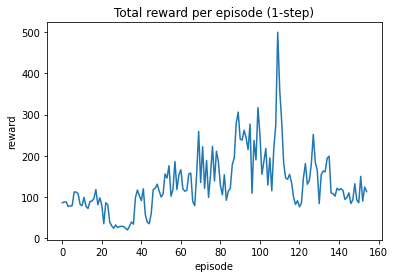

In [9]:
plt.plot(np.arange(len(episode_rewards)), episode_rewards)        #رسم نمودار پاداش ها بر حسب هر واقعه
plt.title("Total reward per episode (1-step)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

# الگوریتم n گامی
از آنجا که این الگوریتم بسیار شبه الگوریتم قبلی است توضیح زیادی داده نشده است.

In [35]:
def train(memory, q_val):                                      #با کمک تخمین مقدار و مقادیر زخیره شده در شی حافظه شبکه را به روز می کند
    values = torch.stack(memory.values)
    q_vals = np.zeros((len(memory), 1))
    for i, (_, _, reward, done) in enumerate(memory.reversed()):
        q_val = reward + gamma*q_val*(1.0-done)
        q_vals[len(memory)-1 - i] = q_val        
    advantage = torch.Tensor(q_vals) - values
    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    actor_loss = (-torch.stack(memory.log_probs)*advantage.detach()).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

In [36]:
episode_rewards = []

for i in range(400):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0

    while not done:
        probs = actor(torch.from_numpy(state).float())
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic(torch.from_numpy(state).float()), reward, done)  
        state = next_state
        
        if done or (steps % max_steps == 0):                                               #اگر تعداد گام لازم گذشته بود یا واقعه تمام شده بود وزن های شبکه را به روز رسانی می کند
            last_q_val = critic(torch.from_numpy(next_state).float()).detach().data.numpy()
            train(memory, last_q_val)
            memory.clear()
    print('Episode {} total rewarde is {} '.format(i,total_reward))
    episode_rewards.append(total_reward)

C:\Users\Nicki\anaconda3\envs\env_pytorch\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode 0 total rewarde is 19.0 
Episode 1 total rewarde is 12.0 
Episode 2 total rewarde is 30.0 
Episode 3 total rewarde is 23.0 
Episode 4 total rewarde is 25.0 
Episode 5 total rewarde is 13.0 
Episode 6 total rewarde is 12.0 
Episode 7 total rewarde is 20.0 
Episode 8 total rewarde is 8.0 
Episode 9 total rewarde is 9.0 
Episode 10 total rewarde is 9.0 
Episode 11 total rewarde is 10.0 
Episode 12 total rewarde is 9.0 
Episode 13 total rewarde is 9.0 
Episode 14 total rewarde is 9.0 
Episode 15 total rewarde is 10.0 
Episode 16 total rewarde is 10.0 
Episode 17 total rewarde is 10.0 
Episode 18 total rewarde is 9.0 
Episode 19 total rewarde is 10.0 
Episode 20 total rewarde is 10.0 
Episode 21 total rewarde is 9.0 
Episode 22 total rewarde is 9.0 
Episode 23 total rewarde is 10.0 
Episode 24 total rewarde is 12.0 
Episode 25 total rewarde is 10.0 
Episode 26 total rewarde is 10.0 
Episode 27 total rewarde is 10.0 
Episode 28 total rewarde is 9.0 
Episode 29 total rewarde is 10.0 


Episode 237 total rewarde is 203.0 
Episode 238 total rewarde is 199.0 
Episode 239 total rewarde is 209.0 
Episode 240 total rewarde is 227.0 
Episode 241 total rewarde is 248.0 
Episode 242 total rewarde is 338.0 
Episode 243 total rewarde is 440.0 
Episode 244 total rewarde is 110.0 
Episode 245 total rewarde is 23.0 
Episode 246 total rewarde is 16.0 
Episode 247 total rewarde is 13.0 
Episode 248 total rewarde is 19.0 
Episode 249 total rewarde is 21.0 
Episode 250 total rewarde is 28.0 
Episode 251 total rewarde is 27.0 
Episode 252 total rewarde is 40.0 
Episode 253 total rewarde is 104.0 
Episode 254 total rewarde is 220.0 
Episode 255 total rewarde is 256.0 
Episode 256 total rewarde is 500.0 
Episode 257 total rewarde is 392.0 
Episode 258 total rewarde is 262.0 
Episode 259 total rewarde is 192.0 
Episode 260 total rewarde is 206.0 
Episode 261 total rewarde is 200.0 
Episode 262 total rewarde is 168.0 
Episode 263 total rewarde is 175.0 
Episode 264 total rewarde is 201.0 


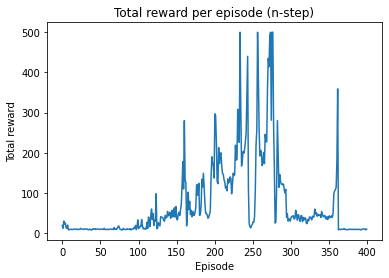

In [37]:
plt.plot(np.arange(len(episode_rewards)), episode_rewards)#خروجی برای اندازه گام 1
plt.title("Total reward per episode (n-step)")
plt.ylabel("Total reward")
plt.xlabel("Episode")
plt.show()

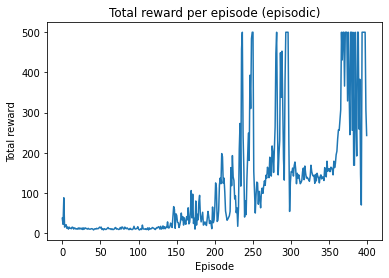

In [17]:
plt.plot(np.arange(len(episode_rewards)), episode_rewards)#6خروجی برای اندازه گام 
plt.title("Total reward per episode (n-step)")
plt.ylabel("Total reward")
plt.xlabel("Episode")
plt.show()

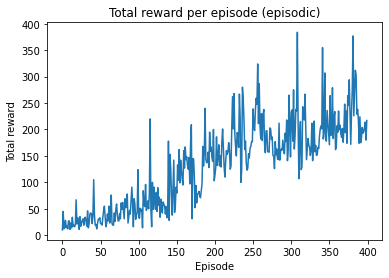

In [21]:
plt.plot(np.arange(len(episode_rewards)), episode_rewards)#20خروجی برای اندازه گام 
plt.title("Total reward per episode (episodic)")
plt.ylabel("Total reward")
plt.xlabel("Episode")
plt.show()

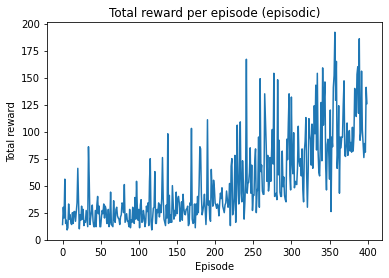

In [25]:
plt.plot(np.arange(len(episode_rewards)), episode_rewards)#200خروجی برای اندازه گام 
plt.title("Total reward per episode (n-step)")
plt.ylabel("Total reward")
plt.xlabel("Episode")
plt.show()